# Accuracy 72.58% SSIM 65.22% Split 0.2

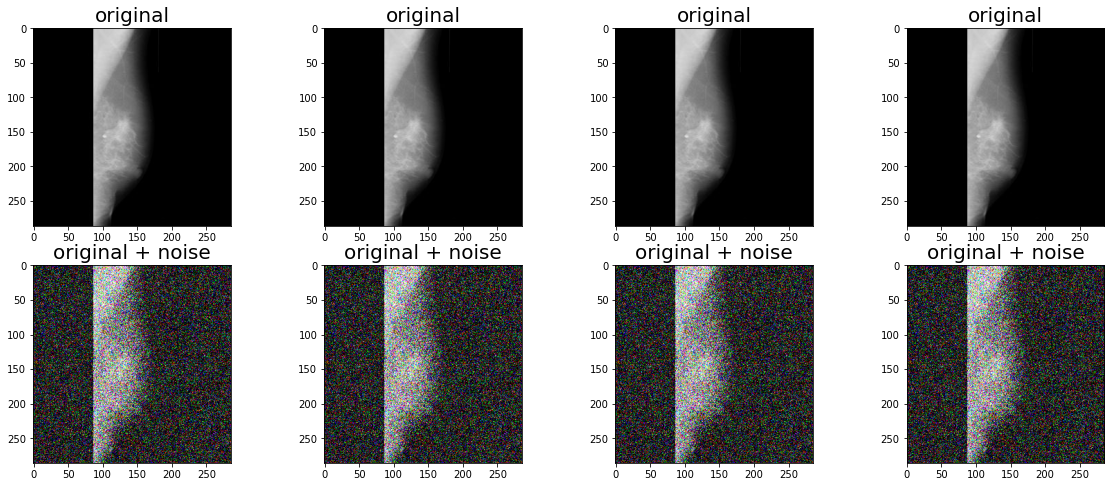

Epoch 1/100
9/9 [==============================] - 2s 148ms/step - loss: 0.6927 - accuracy: 0.2799 - val_loss: 0.6813 - val_accuracy: 0.7258
Epoch 2/100
9/9 [==============================] - 1s 123ms/step - loss: 0.6758 - accuracy: 0.4956 - val_loss: 0.6494 - val_accuracy: 0.7258
Epoch 3/100
9/9 [==============================] - 1s 122ms/step - loss: 0.6347 - accuracy: 0.4954 - val_loss: 0.5705 - val_accuracy: 0.7258
Epoch 4/100
9/9 [==============================] - 1s 122ms/step - loss: 0.5569 - accuracy: 0.4947 - val_loss: 0.5093 - val_accuracy: 0.7258
Epoch 5/100
9/9 [==============================] - 1s 121ms/step - loss: 0.5129 - accuracy: 0.4953 - val_loss: 0.4378 - val_accuracy: 0.7258
Epoch 6/100
9/9 [==============================] - 1s 122ms/step - loss: 0.4388 - accuracy: 0.4943 - val_loss: 0.3503 - val_accuracy: 0.7258
Epoch 7/100
9/9 [==============================] - 1s 122ms/step - loss: 0.3602 - accuracy: 0.4947 - val_loss: 0.2690 - val_accuracy: 0.7258
Epoch 8/100
9

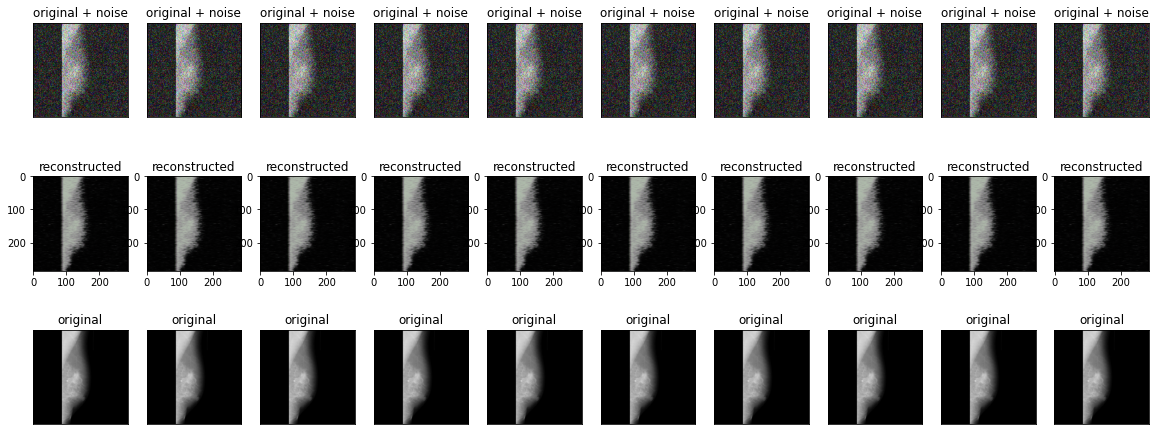

9/9 [==============================] - 0s 29ms/step - loss: 0.1797 - accuracy: 0.7258

Model accuracy:  [0.17973968386650085, 0.7258423566818237]
SSIM: 0.6522298210523312
PSNR: 24.029007731086864



In [91]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

filenames = []
train_data_array = []
test_data_array = []

for file in os.listdir(os.path.join('/content/mini286')):
  if file.startswith('.'):
    continue
  filenames.append(file)

split_1 = int(0.2 * len(filenames))
train_filenames = filenames[split_1:]
test_filenames = filenames[:split_1]

for file in os.listdir(os.path.join('/content/mini286/')):
  if file.startswith('.') or file not in train_filenames:
    continue
  img = Image.open('/content/mini286/'+file)
  numpydata = np.asarray(img)
  train_data_array.append(numpydata)

for l in train_data_array:
  x_train = l.astype('float32') / 255.
  x_train = x_train[..., tf.newaxis] 

for file in os.listdir(os.path.join('/content/mini286/')):
  if file.startswith('.') or file not in test_filenames:
    continue
  img = Image.open('/content/mini286/'+file)
  numpydata = np.asarray(img)
  test_data_array.append(numpydata)

for l in test_data_array:
  x_test = l.astype('float32') / 255.
  x_test = x_test[..., tf.newaxis]

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 4
plt.figure(figsize=(20, 8))
plt.gray()

for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test)) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy)) 
plt.show()

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=(286, 3, 1)),
      Conv2D(16, kernel_size=3, activation='relu', padding='same', strides=1),
      Conv2D(8, kernel_size=3, activation='relu', padding='same', strides=1)])
    
    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = NoiseReducer()

autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

autoencoder.fit(x_train_noisy,
                x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs)) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False)
plt.show()

print("\nModel accuracy: ", autoencoder.evaluate(decoded_imgs,x_test))
print("SSIM: {}".format(ssim(decoded_imgs.numpy(), x_test, win_size=3, multichannel=True)))
print("PSNR: {}\n".format(psnr(decoded_imgs.numpy(), x_test)))

# Accuracy 70.9% SSIM 72.85% Split 0.35

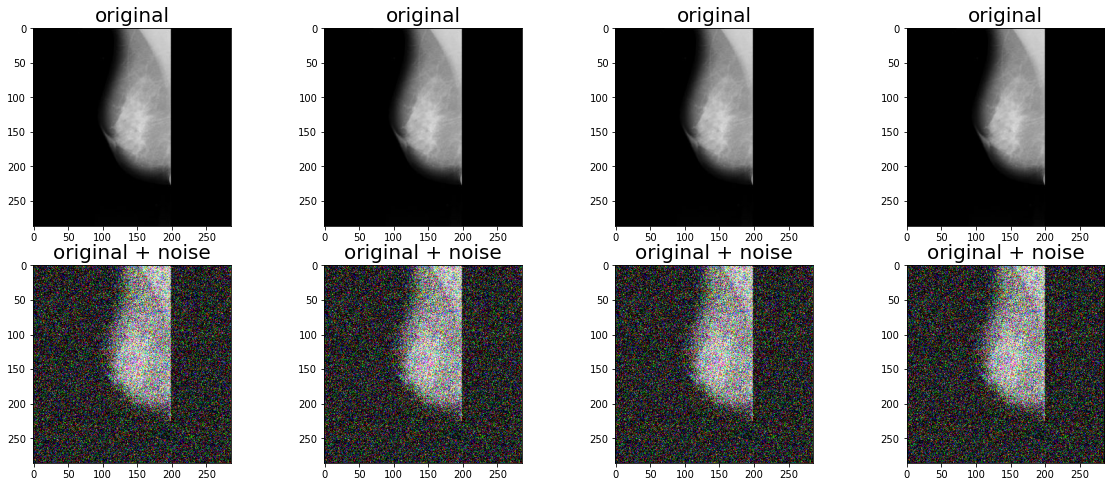

Epoch 1/100
9/9 [==============================] - 2s 154ms/step - loss: 0.6910 - accuracy: 0.3215 - val_loss: 0.6743 - val_accuracy: 0.7075
Epoch 2/100
9/9 [==============================] - 1s 127ms/step - loss: 0.6758 - accuracy: 0.4415 - val_loss: 0.6209 - val_accuracy: 0.7090
Epoch 3/100
9/9 [==============================] - 1s 126ms/step - loss: 0.6421 - accuracy: 0.4419 - val_loss: 0.5082 - val_accuracy: 0.7090
Epoch 4/100
9/9 [==============================] - 1s 127ms/step - loss: 0.5949 - accuracy: 0.4389 - val_loss: 0.3945 - val_accuracy: 0.7090
Epoch 5/100
9/9 [==============================] - 1s 126ms/step - loss: 0.4996 - accuracy: 0.4388 - val_loss: 0.2684 - val_accuracy: 0.7090
Epoch 6/100
9/9 [==============================] - 1s 125ms/step - loss: 0.3994 - accuracy: 0.4427 - val_loss: 0.1978 - val_accuracy: 0.7090
Epoch 7/100
9/9 [==============================] - 1s 127ms/step - loss: 0.3454 - accuracy: 0.4439 - val_loss: 0.1816 - val_accuracy: 0.7090
Epoch 8/100
9

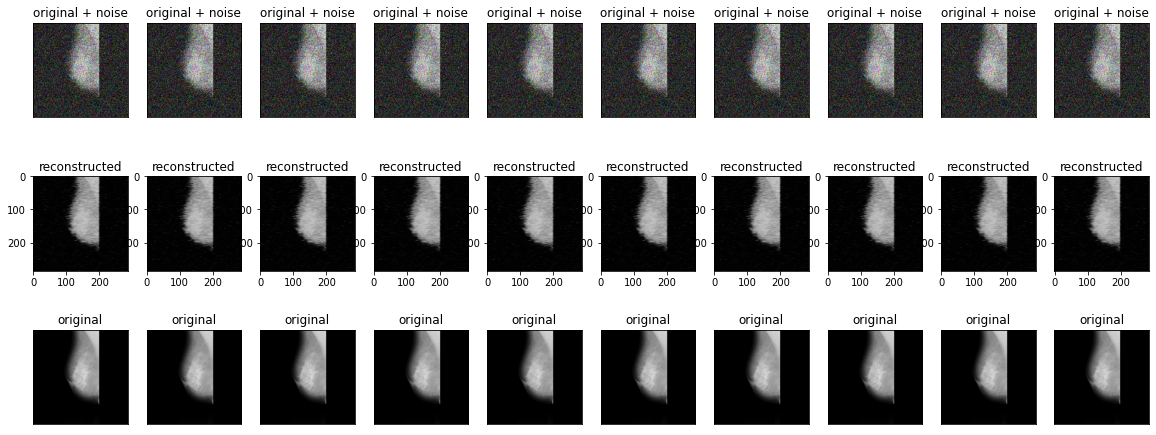

9/9 [==============================] - 0s 28ms/step - loss: 0.1680 - accuracy: 0.7090

Model accuracy:  [0.1680310070514679, 0.7089588642120361]
SSIM: 0.7285047996104341
PSNR: 26.120928229189005



In [19]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

filenames = []
train_data_array = []
test_data_array = []

for file in os.listdir(os.path.join('/content/mini286')):
  if file.startswith('.'):
    continue
  filenames.append(file)

split_1 = int(0.35 * len(filenames))
train_filenames = filenames[split_1:]
test_filenames = filenames[:split_1]

for file in os.listdir(os.path.join('/content/mini286/')):
  if file.startswith('.') or file not in train_filenames:
    continue
  img = Image.open('/content/mini286/'+file)
  numpydata = np.asarray(img)
  train_data_array.append(numpydata)

for l in train_data_array:
  x_train = l.astype('float32') / 255.
  x_train = x_train[..., tf.newaxis] 

for file in os.listdir(os.path.join('/content/mini286/')):
  if file.startswith('.') or file not in test_filenames:
    continue
  img = Image.open('/content/mini286/'+file)
  numpydata = np.asarray(img)
  test_data_array.append(numpydata)

for l in test_data_array:
  x_test = l.astype('float32') / 255.
  x_test = x_test[..., tf.newaxis]

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 4
plt.figure(figsize=(20, 8))
plt.gray()

for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test)) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy)) 
plt.show()

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=(286, 3, 1)),
      Conv2D(16, kernel_size=3, activation='relu', padding='same', strides=1),
      Conv2D(8, kernel_size=3, activation='relu', padding='same', strides=1)])
    
    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = NoiseReducer()

autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

autoencoder.fit(x_train_noisy,
                x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs)) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False)
plt.show()

print("\nModel accuracy: ", autoencoder.evaluate(decoded_imgs,x_test))
print("SSIM: {}".format(ssim(decoded_imgs.numpy(), x_test, win_size=3, multichannel=True)))
print("PSNR: {}\n".format(psnr(decoded_imgs.numpy(), x_test)))

# Test

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

filenames = []
train_data_array = []
test_data_array = []

for file in os.listdir(os.path.join('/content/mini286')):
  if file.startswith('.'):
    continue
  filenames.append(file)

split_1 = int(0.35 * len(filenames))
train_filenames = filenames[split_1:]
test_filenames = filenames[:split_1]

for file in os.listdir(os.path.join('/content/mini286/')):
  if file.startswith('.') or file not in train_filenames:
    continue
  img = Image.open('/content/mini286/'+file)
  numpydata = np.asarray(img)
  train_data_array.append(numpydata)

for l in train_data_array:
  x_train = l.astype('float32') / 255.
  x_train = x_train[..., tf.newaxis] 

for file in os.listdir(os.path.join('/content/mini286/')):
  if file.startswith('.') or file not in test_filenames:
    continue
  img = Image.open('/content/mini286/'+file)
  numpydata = np.asarray(img)
  test_data_array.append(numpydata)

for l in test_data_array:
  x_test = l.astype('float32') / 255.
  x_test = x_test[..., tf.newaxis]

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 4
plt.figure(figsize=(20, 8))
plt.gray()

for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test)) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy)) 
plt.show()

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=(286, 3, 1)),
      Conv2D(16, kernel_size=3, activation='relu', padding='same', strides=1),
      Conv2D(8, kernel_size=3, activation='relu', padding='same', strides=1)])
    
    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = NoiseReducer()

autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

autoencoder.fit(x_train_noisy,
                x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs)) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test)) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False)
plt.show()

print("\nModel accuracy: ", autoencoder.evaluate(decoded_imgs,x_test))
print("SSIM: {}".format(ssim(decoded_imgs.numpy(), x_test, win_size=3, multichannel=True)))
print("PSNR: {}\n".format(psnr(decoded_imgs.numpy(), x_test)))